In [1]:
import pandas as pd  # Data manipulation
import tensorflow as tf  # Machine learning
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [3]:
categories = ["beds", "chairs", "dressers", "lamps", "sofas", "tables"]

In [4]:
df_train = pd.read_csv('./data/datasets/cleaned.csv')

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75697 entries, 0 to 75696
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Image_Name     75697 non-null  object
 1   Category       75697 non-null  object
 2   Style          75697 non-null  object
 3   Category_Path  75697 non-null  object
 4   Full_Path      75697 non-null  object
dtypes: object(5)
memory usage: 2.9+ MB


In [6]:
df_train = df_train.sample(frac=0.05, random_state=42)

In [7]:
INPUT_DIM = (350, 350, 3)
FEATURE_VECTOR_DIM = 128

In [8]:
feat_extractor = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (4, 4), activation='relu', input_shape=INPUT_DIM),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (4, 4), activation='relu'),
    tf.keras.layers.AveragePooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (4, 4), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dense(FEATURE_VECTOR_DIM),
])


feat_extractor.compile(optimizer='adam', loss='mse')

In [9]:
## Initialize the feature vector dictionary
feature_vector = {'Full_Path': [], 'Category': []}
for i in range(FEATURE_VECTOR_DIM):
    feature_vector[f'Feature {i}'] = []

total_images = len(df_train)
processed_images = 0

## Iterate over the rows of the filtered dataframe
for i, row in df_train.iterrows():
    processed_images += 1
    progress_percent = (processed_images / total_images) * 100
    print(f'Processing image {processed_images}/{total_images} - {progress_percent:.2f}% complete', end='\r')

    feature_vector['Full_Path'].append(row['Full_Path'])
    feature_vector['Category'].append(row['Category'])
    with Image.open(row['Full_Path']) as ref:  # Open the image from the row
        ref = ref.resize((350, 350))  # Resize the image if needed
        ref_array = np.array(ref)  # Convert PIL image to NumPy array
        ref_array = ref_array / 255.0  # Normalize pixel values to [0, 1]
        ref_tensor = tf.convert_to_tensor(ref_array, dtype=tf.float32)  # Convert NumPy array to TensorFlow tensor
        ref_tensor = tf.expand_dims(ref_tensor, axis=0)  # Add batch dimension

        ref_feature_vector = feat_extractor.predict(ref_tensor, verbose=0)

        for j, feature in enumerate(ref_feature_vector.reshape(-1)):
            feature_vector[f'Feature {j}'].append(feature)

2024-05-21 07:43:11.081693: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [10]:
# Convert to dataframe
df_feature_vector = pd.DataFrame(feature_vector)
df_feature_vector.to_csv("feature_vector.csv", index=False)
df_feature_vector.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3785 entries, 0 to 3784
Columns: 130 entries, Full_Path to Feature 127
dtypes: float32(128), object(2)
memory usage: 1.9+ MB


In [11]:
df_feature_vector = pd.read_csv("feature_vector.csv",delimiter=',')
df_feature_vector.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3785 entries, 0 to 3784
Columns: 130 entries, Full_Path to Feature 127
dtypes: float64(128), object(2)
memory usage: 3.8+ MB


In [12]:
# Define the classify function
def classify(image_path: str, model: tf.keras.Model, verbose: bool = False, return_original: bool = True) -> tuple:
    """
    Uses a trained machine learning model to classify an image loaded from disk.

    :param image_path: Path to the image to be classified.
    :param model: Pre-loaded classifier model to be used.
    :param verbose: Verbose output.
    :param return_original: Whether to return the original image or the processed image.
    :return: The original/processed image (PIL.image) and its classification (str).
    """
    
    # Load the image from the given path
    im_original = Image.open(image_path)
    
    # Resize the image to the target size
    im_processed = im_original.resize((350, 350))
    
    # Convert the PIL image to a NumPy array and normalize pixel values to [0, 1]
    im_array = np.array(im_processed) / 255.0
    
    # Convert the NumPy array to a TensorFlow tensor and add a batch dimension
    im_tensor = tf.convert_to_tensor(im_array, dtype=tf.float32)
    im_tensor = tf.expand_dims(im_tensor, axis=0)
    
    # Predict the class of the processed image
    pred = model.predict(im_tensor, verbose=1 if verbose else 0)
    
    # Get the index of the predicted class
    pred_class_idx = tf.argmax(pred, axis=1).numpy()[0]
    
    # Get the label of the predicted class
    # Ensure that CLASS_LABELS is defined elsewhere in your code
    pred_class_label = categories[pred_class_idx]
    
    # Return the original or processed image along with the predicted class label
    if return_original:
        return im_original, pred_class_label
    else:
        return im_processed, pred_class_label

In [13]:
# Load CNN model (without compiling)
cnn = tf.keras.models.load_model("./cache/models/t1_large_100_cnn/epoch_21.h5",compile=False)

# Compile model
cnn.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
) 
# Summarise the model
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 350, 350, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 350, 350, 16)     64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 350, 350, 16)      2320      
                                                                 
 batch_normalization_1 (Batc  (None, 350, 350, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 175, 175, 16)     0         
 )                                                               
                                                        

In [14]:
from sklearn.cluster import KMeans

# Drop the 'Path' and 'Category' columns
distortions = []
X = df_feature_vector.drop(columns=['Full_Path', 'Category'])
K = range(1,11)
for k in K:
    kmeans = KMeans(n_clusters= k, init="k-means++", n_init='auto')
    kmeans.fit(X)
    distortions.append(kmeans.inertia_)

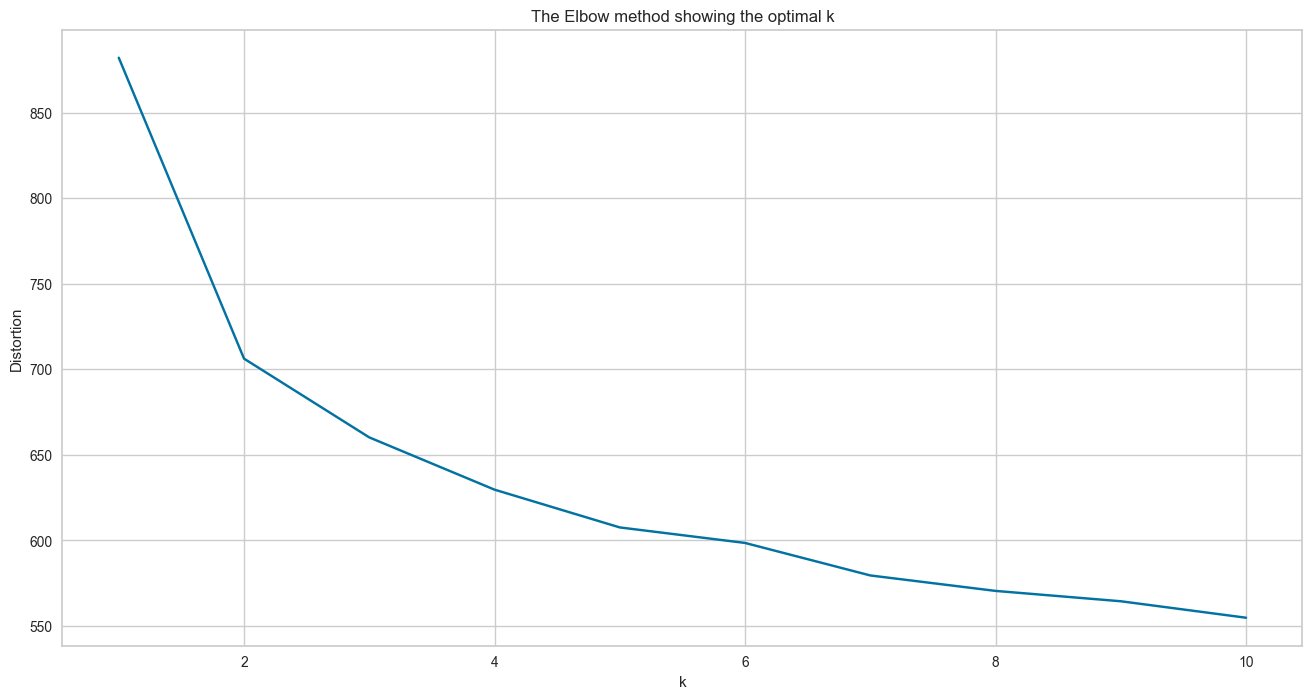

In [15]:
plt.figure(figsize = (16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow method showing the optimal k')
plt.show()

In [16]:
## Setup parameters for KMeans model
selected_n_clusters = 3
clu = KMeans(n_clusters=selected_n_clusters, init="k-means++", n_init='auto')

# Setup the number of samples
sample_number = 8
num_recommendations = 10

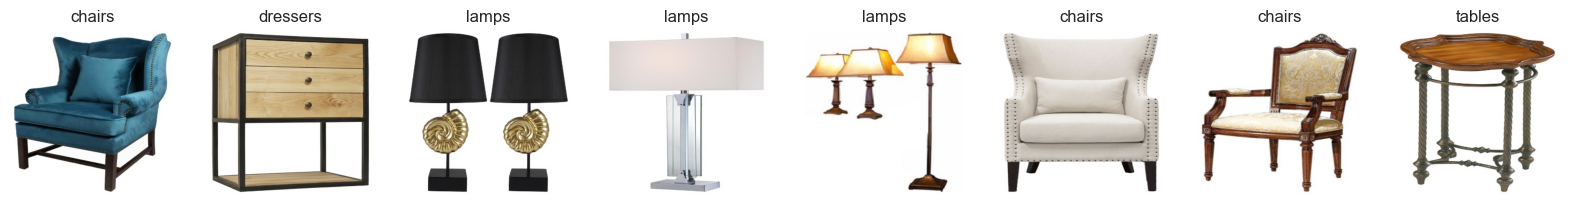

In [17]:
# Sample 8 random images from filtered_df
random_images = df_train.sample(sample_number)

# Create subplots
figure, axes = plt.subplots(1, sample_number, figsize=(20, 5))

# Iterate over each randomly selected image
for idx, (img_idx, img_row) in enumerate(random_images.iterrows()):
    # Load the image using PIL
    with Image.open(img_row['Full_Path']) as image:
        # Display the image
        axes[idx].imshow(image)
        axes[idx].set_title(img_row['Category'], fontsize=12)
        axes[idx].axis('off')

# Show the plot
plt.show()


In [18]:
feat_extractor.save("feature_extract", overwrite=True)


INFO:tensorflow:Assets written to: feature_extract/assets


INFO:tensorflow:Assets written to: feature_extract/assets


In [19]:
results = []

## Load the feature extractor model
fe = tf.keras.models.load_model("feature_extract")

## Iterate over each randomly selected image
for ref_path in random_images['Full_Path']:
    with Image.open(ref_path) as ref:  # Open the image from the row
        # Classify the image into category
        ref_processed, ref_class = classify(f'{ref_path}', cnn, return_original=False)
        recommendation = df_feature_vector[df_feature_vector['Category'] == ref_class]

        # Extract reference image feature vector
        ref_processed = np.squeeze(ref_processed)
        ref_feature_vector = fe.predict(
            tf.expand_dims(ref_processed, axis=0),
            verbose=0
        )
        ref_feature_vector = ref_feature_vector.astype(float)
        ref_feature_vector = ref_feature_vector.reshape(1, -1)

        # Cluster reference image
        clu.fit(recommendation.drop(['Full_Path', 'Category'], axis='columns').values)
        ref_cluster = clu.predict(ref_feature_vector)
        ref_cluster_indices = np.where(clu.labels_ == ref_cluster)[0]
        recommendation = recommendation.iloc[ref_cluster_indices]

        # Exclude the original image from the recommendation set
        recommendation = recommendation[recommendation['Full_Path'] != ref_path]

        # Rank cluster and produce top cosine similarity recommendations
        cosine_similarities = cosine_similarity(ref_feature_vector, recommendation.drop(['Full_Path', 'Category'], axis='columns'))

        # Sort the cosine similarities in descending order
        sorted_ref_cluster_indices = np.argsort(-cosine_similarities.flatten())
        top_ref_cluster_indices = sorted_ref_cluster_indices[:num_recommendations]
        recommendation = recommendation.iloc[top_ref_cluster_indices]

        results.append(recommendation['Full_Path'].values)

print(results)


[array(['./data/datasets/cleaned/chairs/Traditional/10721traditional-armchairs-and-accent-chairs.jpg',
       './data/datasets/cleaned/chairs/Traditional/11225traditional-armchairs-and-accent-chairs.jpg',
       './data/datasets/cleaned/chairs/Transitional/23294transitional-dining-chairs.jpg',
       './data/datasets/cleaned/chairs/Midcentury/20030midcentury-armchairs-and-accent-chairs.jpg',
       './data/datasets/cleaned/chairs/Contemporary/16318contemporary-living-room-chairs.jpg',
       './data/datasets/cleaned/chairs/Traditional/12881traditional-dining-chairs.jpg',
       './data/datasets/cleaned/chairs/Traditional/11339traditional-dining-chairs.jpg',
       './data/datasets/cleaned/chairs/Traditional/10538traditional-dining-chairs.jpg',
       './data/datasets/cleaned/chairs/Tropical/26250tropical-dining-chairs.jpg',
       './data/datasets/cleaned/chairs/Traditional/10465traditional-armchairs-and-accent-chairs.jpg'],
      dtype=object), array(['./data/datasets/cleaned/dressers

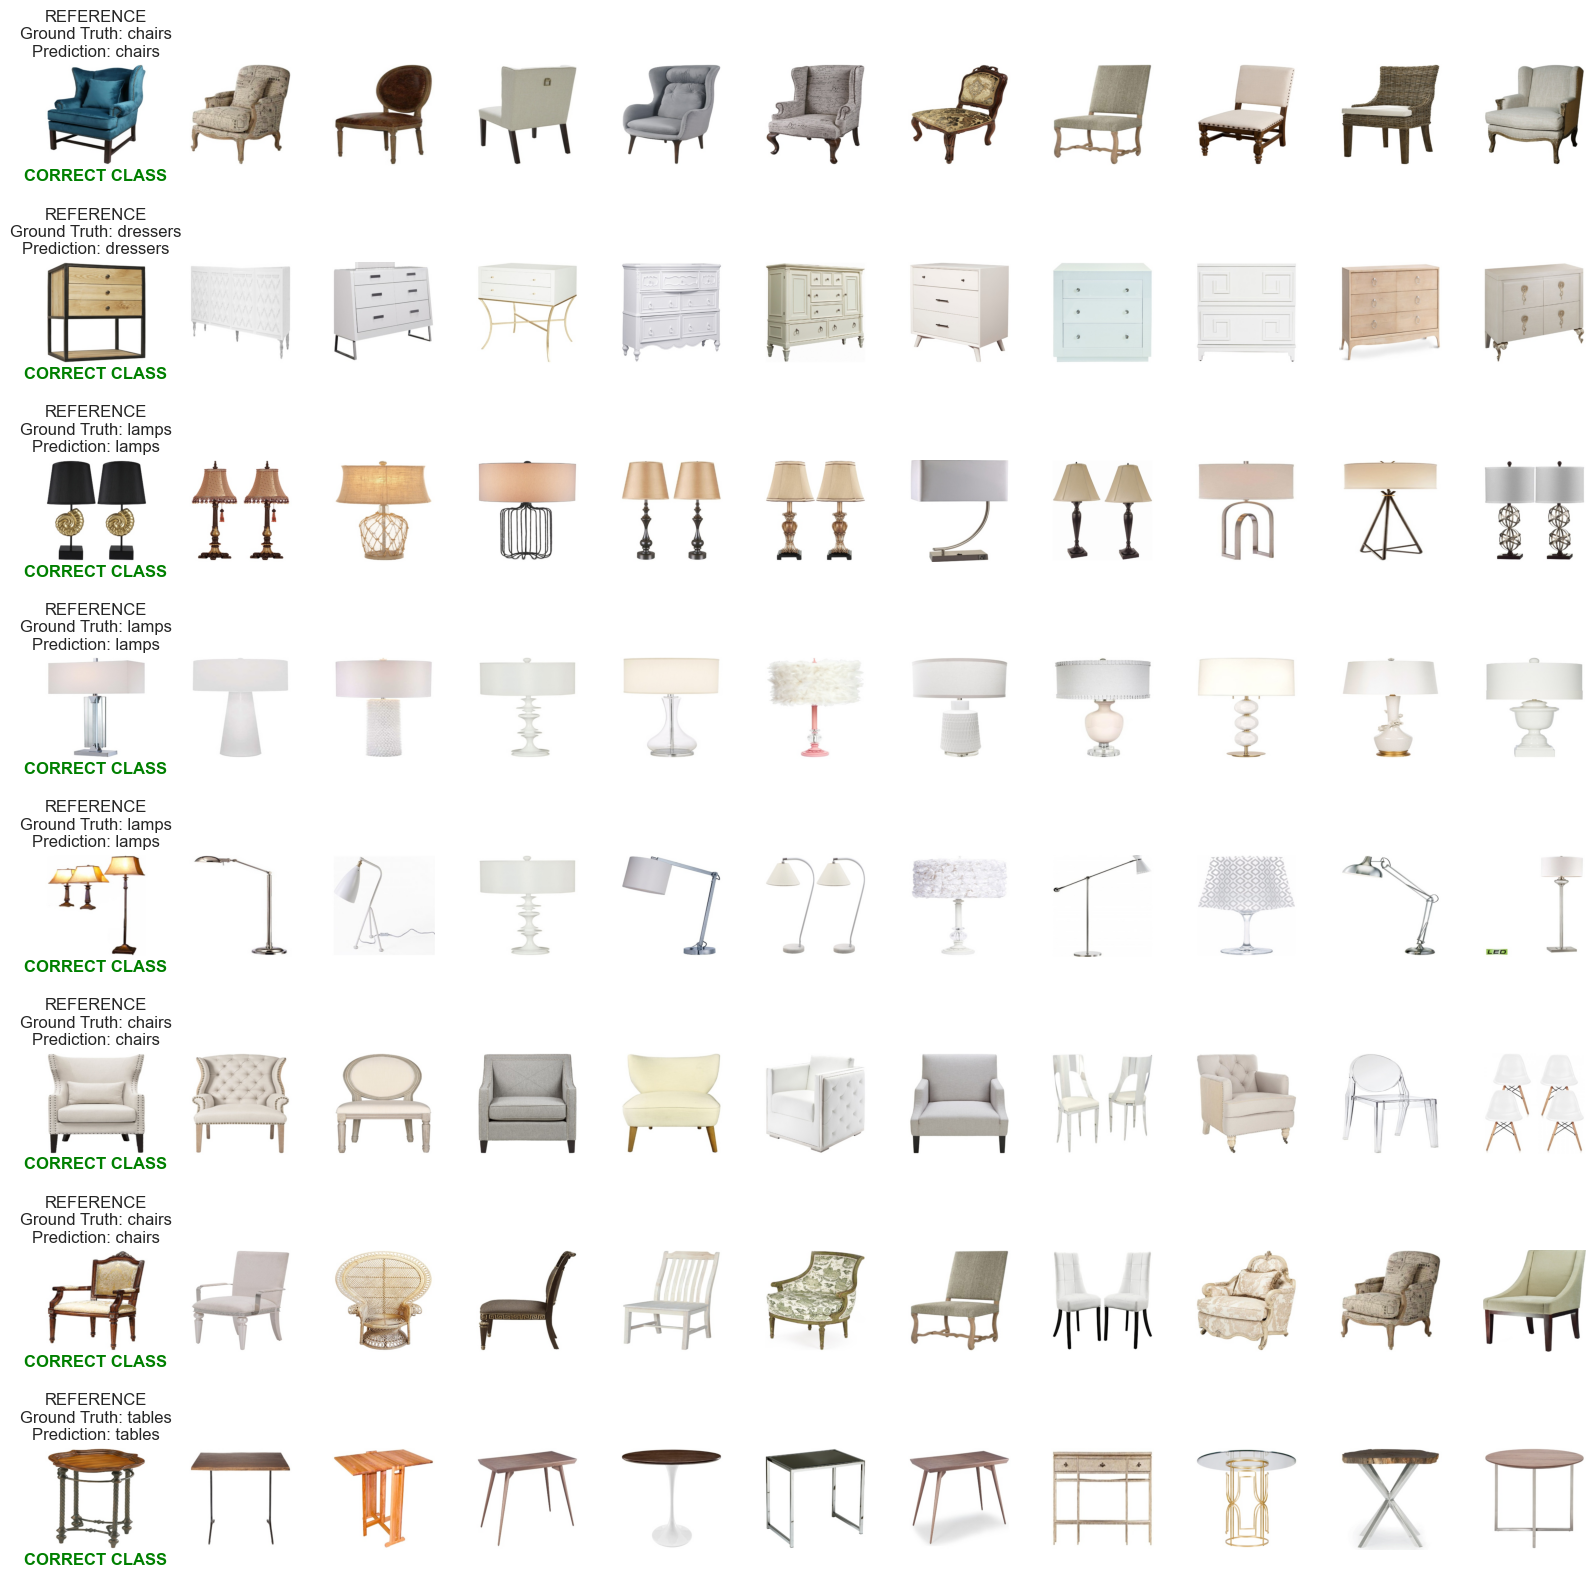

In [21]:
fig, ax = plt.subplots(8, 11, figsize=(16, 16))
for i, ref_path in enumerate(random_images['Full_Path']):
    with Image.open(f'{ref_path}') as ref:
        true_label = ref_path.split('/')[-3]
        _, predicted_label = classify(f'{ref_path}', cnn)

        ax[i][0].imshow(ref)
        ax[i][0].set_title(
            f'REFERENCE\n'
            f'Ground Truth: {true_label}\n'
            f'Prediction: {predicted_label}',
            fontsize=12
        )
        ax[i][0].text(
            0.5, -0.08, f'{"CORRECT CLASS" if true_label == predicted_label else "INCORRECT CLASS"}',
            horizontalalignment='center',
            verticalalignment='center_baseline',
            transform=ax[i][0].transAxes,
            fontsize=12,
            color='green' if true_label == predicted_label else 'red',
            weight='bold'
        )
        ax[i][0].axis('off')

    for j, rec_path in enumerate(results[i], start=1):
        with Image.open(f'{rec_path}') as rec:
            ax[i][j].imshow(rec)
            ax[i][j].axis('off')


plt.tight_layout()
plt.show()